In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import psutil
import tracemalloc

# Thiết lập seed cho tính tái tạo
np.random.seed(42)
torch.manual_seed(42)

# Cài đặt các thông số chung
d_model = 64  # Kích thước mô hình
n_heads = 4  # Số đầu attention
d_k = d_model // n_heads  # Kích thước của mỗi đầu
seq_len = 10  # Độ dài chuỗi mẫu

## Các hàm tiện ích


In [2]:
# Tạo dữ liệu mẫu
def generate_sample_data(batch_size=2):
    # Tạo batch dữ liệu ngẫu nhiên
    x = torch.randn(batch_size, seq_len, d_model)
    return x


# Hàm hiển thị ma trận attention
def plot_attention_matrix(attention_matrix, title="Attention Matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.tight_layout()
    plt.show()


# Hàm hiển thị so sánh độ phức tạp
def plot_complexity_comparison():
    n_values = np.arange(100, 10001, 100)
    
    # Tính độ phức tạp cho các cơ chế khác nhau
    mha_complexity = n_values**2  # O(n²) - Self Attention
    mqa_complexity = n_values**2  # O(n²) - Multi Query Attention
    gqa_complexity = n_values**2  # O(n²) - Grouped Query Attention
    flash_complexity = n_values**2  # O(n²) nhưng với hằng số nhỏ hơn - FlashAttention
    linear_complexity = n_values  # O(n) - Linear Attention 
    sparse_complexity = n_values * np.log(n_values)  # O(n log n) - Sparse Attention
    rope_complexity = n_values**2  # O(n²) - RoPE
    
    plt.figure(figsize=(12, 8))
    plt.plot(n_values, mha_complexity, label="Self-Attention (MHA): O(n²)", linewidth=2)
    plt.plot(n_values, mqa_complexity * 0.8, label="Multi-Query Attention (MQA): O(n²)", linewidth=2)
    plt.plot(n_values, gqa_complexity * 0.9, label="Grouped-Query Attention (GQA): O(n²)", linewidth=2)
    plt.plot(n_values, flash_complexity * 0.6, label="FlashAttention: O(n²)", linewidth=2)
    plt.plot(n_values, linear_complexity, label="Linear Attention: O(n)", linewidth=2)
    plt.plot(n_values, sparse_complexity, label="Sparse Attention: O(n log n)", linewidth=2)
    plt.plot(n_values, rope_complexity * 1.1, label="RoPE: O(n²)", linewidth=2)
    
    plt.xlabel("Độ dài chuỗi (n)")
    plt.ylabel("Độ phức tạp tính toán (tương đối)")
    plt.title("So sánh độ phức tạp tính toán của các cơ chế attention")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()


# Hàm hiển thị so sánh yêu cầu bộ nhớ
def plot_memory_comparison():
    n_values = np.arange(100, 10001, 100)
    h = 16  # Số đầu attention 
    g = 4   # Số nhóm trong GQA
    
    # Tính yêu cầu bộ nhớ cho các cơ chế khác nhau
    mha_memory = 2 * h * n_values  # Self-Attention: 2 × H × n × d_k
    mqa_memory = 2 * n_values      # Multi-Query: 2 × n × d_k  
    gqa_memory = 2 * g * n_values  # Grouped-Query: 2 × G × n × d_k
    flash_memory = n_values        # FlashAttention: O(n)
    linear_memory = n_values       # Linear Attention: O(n)
    sparse_memory = n_values * np.log(n_values)  # Sparse: O(n log n)
    rope_memory = 2 * h * n_values # RoPE: Similar to Self-Attention
    
    plt.figure(figsize=(12, 8))
    plt.plot(n_values, mha_memory, label=f"Self-Attention (MHA): 2 × {h} × n", linewidth=2)
    plt.plot(n_values, mqa_memory, label="Multi-Query (MQA): 2 × n", linewidth=2)
    plt.plot(n_values, gqa_memory, label=f"Grouped-Query (GQA): 2 × {g} × n", linewidth=2)
    plt.plot(n_values, flash_memory, label="FlashAttention: O(n)", linewidth=2)
    plt.plot(n_values, linear_memory, label="Linear Attention: O(n)", linewidth=2)
    plt.plot(n_values, sparse_memory, label="Sparse Attention: O(n log n)", linewidth=2)
    plt.plot(n_values, rope_memory, label=f"RoPE: 2 × {h} × n", linewidth=2)
    
    plt.xlabel("Độ dài chuỗi (n)")
    plt.ylabel("Yêu cầu bộ nhớ (tương đối)")
    plt.title("So sánh yêu cầu bộ nhớ của các cơ chế attention")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

## 1. Self-Attention

Self-Attention là nền tảng của kiến trúc Transformer, cho phép mỗi token tương tác với tất cả các token khác trong chuỗi. Cơ chế này tính toán ma trận attention đầy đủ với độ phức tạp O(n²).

### Nguyên lý hoạt động

1. Tạo ra các vector Query (Q), Key (K) và Value (V) cho mỗi token
2. Tính điểm số attention bằng tích vô hướng giữa Q và K
3. Chuẩn hóa điểm số bằng hàm softmax
4. Tính đầu ra bằng cách nhân trọng số attention với V

### Công thức toán học

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Cài đặt


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Các lớp tuyến tính cho Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành nhiều đầu
        # (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        # Chuyển vị để đưa n_heads lên trước
        # (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q, K, V
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_model)
        v = self.W_v(x)  # (batch_size, seq_len, d_model)

        # Tách thành nhiều đầu
        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, d_k)
        k = self.split_heads(k)  # (batch_size, n_heads, seq_len, d_k)
        v = self.split_heads(v)  # (batch_size, n_heads, seq_len, d_k)

        # Tính điểm số attention
        # matmul: (batch_size, n_heads, seq_len, d_k) x (batch_size, n_heads, d_k, seq_len)
        # -> (batch_size, n_heads, seq_len, seq_len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Áp dụng softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Tính đầu ra
        # matmul: (batch_size, n_heads, seq_len, seq_len) x (batch_size, n_heads, seq_len, d_k)
        # -> (batch_size, n_heads, seq_len, d_k)
        output = torch.matmul(attention_weights, v)

        # Ghép các đầu lại
        # (batch_size, seq_len, n_heads, d_k)
        output = output.transpose(1, 2).contiguous()

        # (batch_size, seq_len, d_model)
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            return output, attention_weights
        return output

### Ví dụ minh họa


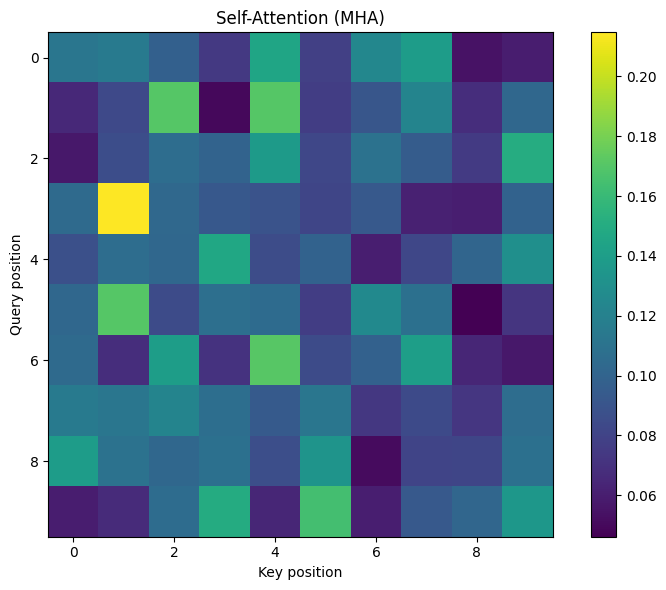

In [4]:
# Tạo dữ liệu mẫu
x = generate_sample_data(batch_size=1)

# Khởi tạo mô hình
mha = SelfAttention(d_model, n_heads)

# Chạy forward pass và lấy ma trận attention
_, mha_attn = mha(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(mha_attn[0, 0].detach().numpy(), title="Self-Attention (MHA)")

## 2. Multi-Query Attention (MQA)

Multi-Query Attention (MQA) là một biến thể của self-attention, giảm yêu cầu bộ nhớ bằng cách sử dụng chung một ma trận Key và một ma trận Value cho tất cả các đầu attention, chỉ có ma trận Query là khác nhau giữa các đầu.

### Nguyên lý hoạt động

1. Tạo ra nhiều vector Query (Q) khác nhau cho mỗi đầu attention
2. Tạo ra một vector Key (K) và một vector Value (V) dùng chung cho tất cả các đầu
3. Tính điểm số attention cho mỗi đầu bằng tích vô hướng giữa Q và K
4. Chuẩn hóa điểm số bằng hàm softmax
5. Tính đầu ra cho mỗi đầu bằng cách nhân trọng số attention với V

### Cài đặt


In [5]:
class MultiQueryAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiQueryAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Nhiều ma trận Q, nhưng chỉ một ma trận K và V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, self.d_k)  # Chỉ một đầu cho K
        self.W_v = nn.Linear(d_model, self.d_k)  # Chỉ một đầu cho V
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads_q(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành nhiều đầu cho Q
        # (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        # (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q (nhiều đầu), K và V (một đầu)
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_k)
        v = self.W_v(x)  # (batch_size, seq_len, d_k)

        # Tách Q thành nhiều đầu
        q = self.split_heads_q(q)  # (batch_size, n_heads, seq_len, d_k)

        # Mở rộng K và V cho tất cả các đầu
        # (batch_size, 1, seq_len, d_k) -> (batch_size, n_heads, seq_len, d_k)
        k = k.unsqueeze(1).expand(-1, self.n_heads, -1, -1)
        v = v.unsqueeze(1).expand(-1, self.n_heads, -1, -1)

        # Tính điểm số attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Áp dụng softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Tính đầu ra
        output = torch.matmul(attention_weights, v)

        # Ghép các đầu lại
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            return output, attention_weights
        return output

### Ví dụ minh họa


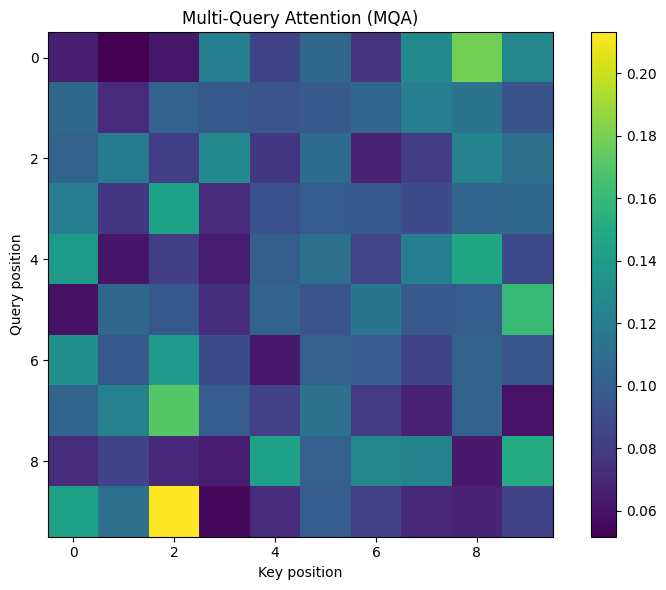

In [6]:
# Khởi tạo mô hình
mqa = MultiQueryAttention(d_model, n_heads)

# Chạy forward pass và lấy ma trận attention
_, mqa_attn = mqa(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(
    mqa_attn[0, 0].detach().numpy(), title="Multi-Query Attention (MQA)"
)

## 3. Grouped-Query Attention (GQA)

Grouped-Query Attention (GQA) là một sự cân bằng giữa MHA và MQA, chia các đầu attention thành các nhóm, mỗi nhóm dùng chung một ma trận Key và một ma trận Value.

### Nguyên lý hoạt động

1. Chia các đầu attention thành G nhóm (với G < H)
2. Mỗi đầu có ma trận Query (Q) riêng biệt
3. Các đầu trong cùng một nhóm dùng chung ma trận Key (K) và Value (V)
4. Tính điểm số attention cho mỗi đầu bằng tích vô hướng giữa Q và K của nhóm tương ứng
5. Chuẩn hóa điểm số bằng hàm softmax
6. Tính đầu ra cho mỗi đầu bằng cách nhân trọng số attention với V của nhóm tương ứng

### Cài đặt


In [7]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, n_heads, n_groups):
        super(GroupedQueryAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_groups = n_groups
        self.heads_per_group = n_heads // n_groups
        self.d_k = d_model // n_heads

        # Nhiều ma trận Q, nhưng chỉ n_groups ma trận K và V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model // self.heads_per_group)
        self.W_v = nn.Linear(d_model, d_model // self.heads_per_group)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads_q(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành nhiều đầu cho Q
        # (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        # (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)

    def split_heads_kv(self, x):
        # x shape: (batch_size, seq_len, d_model // heads_per_group)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành n_groups đầu cho K và V
        # (batch_size, seq_len, n_groups, d_k)
        x = x.view(batch_size, seq_len, self.n_groups, self.d_k)

        # (batch_size, n_groups, seq_len, d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q (nhiều đầu), K và V (n_groups đầu)
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_model // heads_per_group)
        v = self.W_v(x)  # (batch_size, seq_len, d_model // heads_per_group)

        # Tách Q thành nhiều đầu
        q = self.split_heads_q(q)  # (batch_size, n_heads, seq_len, d_k)

        # Tách K và V thành n_groups đầu
        k = self.split_heads_kv(k)  # (batch_size, n_groups, seq_len, d_k)
        v = self.split_heads_kv(v)  # (batch_size, n_groups, seq_len, d_k)

        # Mở rộng K và V cho mỗi nhóm
        # Tạo mapping từ head index -> group index
        head_to_group = (
            torch.arange(self.n_heads, device=x.device) // self.heads_per_group
        )

        # Lưu trữ đầu ra cho mỗi đầu
        outputs = []
        attention_weights_list = []

        # Xử lý từng đầu attention
        for h in range(self.n_heads):
            g = head_to_group[h]  # Nhóm của đầu hiện tại

            # Lấy query cho đầu hiện tại và key/value cho nhóm tương ứng
            q_h = q[:, h]  # (batch_size, seq_len, d_k)
            k_g = k[:, g]  # (batch_size, seq_len, d_k)
            v_g = v[:, g]  # (batch_size, seq_len, d_k)

            # Tính điểm số attention
            scores = torch.matmul(q_h, k_g.transpose(-2, -1)) / math.sqrt(self.d_k)

            # Áp dụng softmax
            attention_weights = F.softmax(scores, dim=-1)
            attention_weights_list.append(attention_weights)

            # Tính đầu ra cho đầu hiện tại
            output_h = torch.matmul(
                attention_weights, v_g
            )  # (batch_size, seq_len, d_k)
            outputs.append(output_h)

        # Ghép đầu ra từ tất cả các đầu
        # (batch_size, n_heads, seq_len, d_k)
        output = torch.stack(outputs, dim=1)

        # (batch_size, seq_len, n_heads, d_k)
        output = output.transpose(1, 2).contiguous()

        # (batch_size, seq_len, d_model)
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            # (batch_size, n_heads, seq_len, seq_len)
            attention_weights = torch.stack(attention_weights_list, dim=1)
            return output, attention_weights
        return output

### Ví dụ minh họa


c:\Users\NGUYEN\miniconda3\envs\py39\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


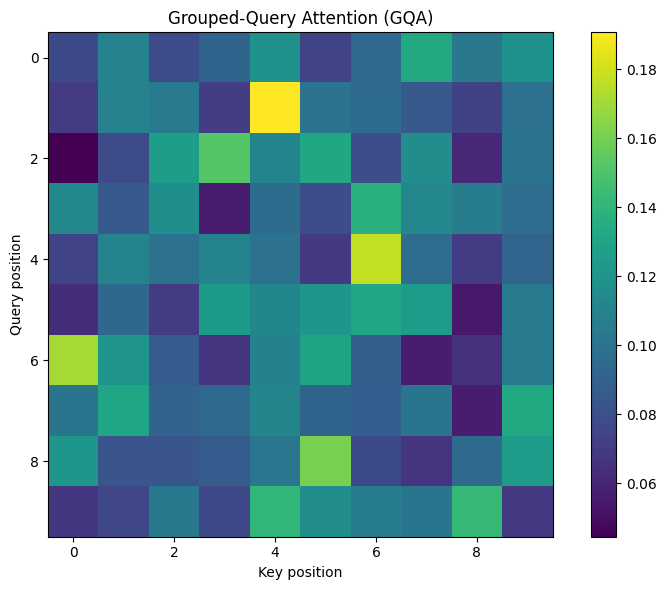

In [8]:
# Khởi tạo mô hình
gqa = GroupedQueryAttention(d_model, n_heads, n_groups=2)

# Chạy forward pass và lấy ma trận attention
_, gqa_attn = gqa(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(
    gqa_attn[0, 0].detach().numpy(), title="Grouped-Query Attention (GQA)"
)

## 4. Linear Attention

Linear Attention giảm độ phức tạp tính toán và bộ nhớ từ O(n²) xuống O(n) bằng cách sử dụng các hàm ánh xạ đặc trưng thay cho hàm softmax.

### Nguyên lý hoạt động

1. Áp dụng hàm ánh xạ đặc trưng φ cho các ma trận Query và Key
2. Tính ma trận trung gian KV = φ(K)^T × V
3. Tính đầu ra cuối cùng Output = φ(Q) × KV
4. Chuẩn hóa đầu ra (tùy chọn)

### Công thức toán học

$$\text{LinearAttention}(Q, K, V) = \phi(Q) \times (\phi(K)^T \times V)$$

### Cài đặt


In [9]:
class LinearAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(LinearAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Các lớp tuyến tính cho Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành nhiều đầu
        # (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        # Chuyển vị để đưa n_heads lên trước
        # (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)

    def feature_map(self, x):
        # Sử dụng ELU+1 làm hàm ánh xạ đặc trưng
        return F.elu(x) + 1

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q, K, V
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_model)
        v = self.W_v(x)  # (batch_size, seq_len, d_model)

        # Tách thành nhiều đầu
        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, d_k)
        k = self.split_heads(k)  # (batch_size, n_heads, seq_len, d_k)
        v = self.split_heads(v)  # (batch_size, n_heads, seq_len, d_k)

        # Áp dụng hàm ánh xạ đặc trưng
        q = self.feature_map(q)
        k = self.feature_map(k)

        # Tính KV trước
        # (batch_size, n_heads, d_k, d_k)
        kv = torch.matmul(k.transpose(-2, -1), v)

        # Tính đầu ra
        # (batch_size, n_heads, seq_len, d_k)
        output = torch.matmul(q, kv)

        # Chuẩn hóa
        # (batch_size, n_heads, seq_len, 1)
        z = torch.matmul(q, torch.sum(k, dim=2).unsqueeze(-1))

        # Áp dụng chuẩn hóa
        output = output / (z + 1e-8)

        # Ghép các đầu lại
        # (batch_size, seq_len, n_heads, d_k)
        output = output.transpose(1, 2).contiguous()

        # (batch_size, seq_len, d_model)
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            # Tính ma trận attention tương đương (cho mục đích hiển thị)
            # Lưu ý: Đây không phải là ma trận attention thực tế được sử dụng trong tính toán
            attention_weights = torch.matmul(q, k.transpose(-2, -1))
            attention_weights = attention_weights / torch.sum(
                attention_weights, dim=-1, keepdim=True
            )
            return output, attention_weights
        return output

### Ví dụ minh họa


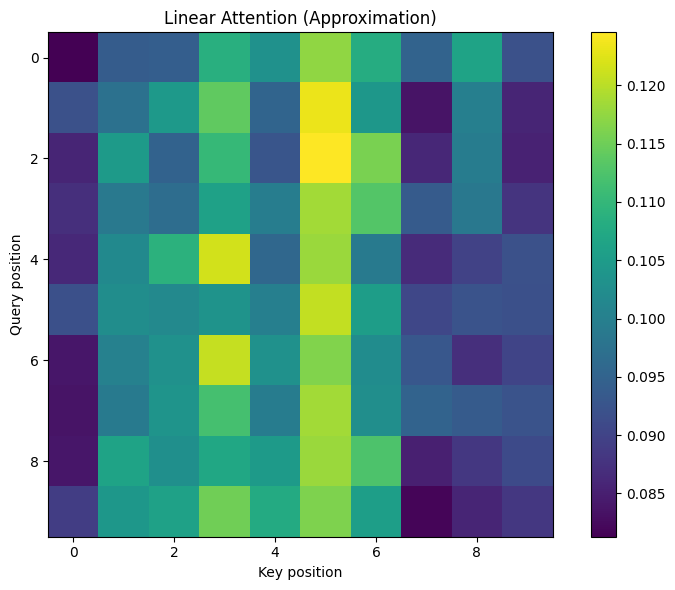

In [10]:
# Khởi tạo mô hình
linear_attn = LinearAttention(d_model, n_heads)

# Chạy forward pass và lấy ma trận attention
_, linear_attn_approx = linear_attn(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(
    linear_attn_approx[0, 0].detach().numpy(), title="Linear Attention (Approximation)"
)

## 5. Sparse Attention

Sparse Attention chỉ tính toán attention cho một tập con các cặp token thay vì tất cả các cặp có thể, giảm độ phức tạp xuống O(n√n) hoặc thậm chí O(n·log(n)).

### Nguyên lý hoạt động

1. Tạo ra một ma trận mặt nạ thưa (sparse mask) để xác định các cặp token nào được phép tương tác
2. Tính điểm số attention như trong self-attention thông thường
3. Áp dụng mặt nạ để chỉ giữ lại các điểm số cho các cặp token được phép tương tác
4. Áp dụng softmax và tính đầu ra như thông thường

### Cài đặt (Local Banded Pattern)


In [11]:
class SparseAttention(nn.Module):
    def __init__(self, d_model, n_heads, window_size=3):
        super(SparseAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.window_size = window_size

        # Các lớp tuyến tính cho Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành nhiều đầu
        # (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        # Chuyển vị để đưa n_heads lên trước
        # (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q, K, V
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_model)
        v = self.W_v(x)  # (batch_size, seq_len, d_model)

        # Tách thành nhiều đầu
        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, d_k)
        k = self.split_heads(k)  # (batch_size, n_heads, seq_len, d_k)
        v = self.split_heads(v)  # (batch_size, n_heads, seq_len, d_k)

        # Tính điểm số attention
        # matmul: (batch_size, n_heads, seq_len, d_k) x (batch_size, n_heads, d_k, seq_len)
        # -> (batch_size, n_heads, seq_len, seq_len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Tạo mặt nạ cho mẫu dải băng cục bộ
        mask = torch.zeros_like(scores)
        for i in range(seq_len):
            start = max(0, i - self.window_size // 2)
            end = min(seq_len, i + self.window_size // 2 + 1)
            mask[:, :, i, start:end] = 1

        # Áp dụng mặt nạ
        scores = scores.masked_fill(mask == 0, -1e9)

        # Áp dụng softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Tính đầu ra
        # matmul: (batch_size, n_heads, seq_len, seq_len) x (batch_size, n_heads, seq_len, d_k)
        # -> (batch_size, n_heads, seq_len, d_k)
        output = torch.matmul(attention_weights, v)

        # Ghép các đầu lại
        # (batch_size, seq_len, n_heads, d_k)
        output = output.transpose(1, 2).contiguous()

        # (batch_size, seq_len, d_model)
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            return output, attention_weights
        return output

### Ví dụ minh họa


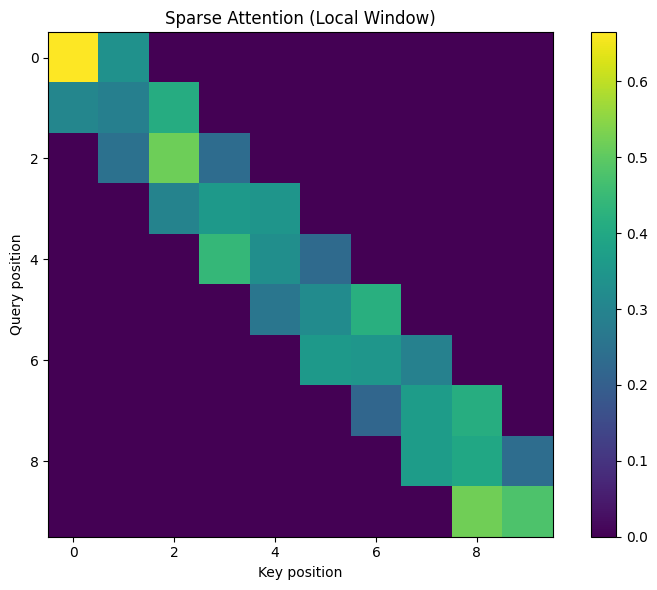

In [12]:
# Khởi tạo mô hình
sparse_attn = SparseAttention(d_model, n_heads, window_size=3)

# Chạy forward pass và lấy ma trận attention
_, sparse_attn_weights = sparse_attn(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(
    sparse_attn_weights[0, 0].detach().numpy(), title="Sparse Attention (Local Window)"
)

## 6. Rotary Positional Embedding (RoPE)

Rotary Positional Embedding (RoPE) mã hóa thông tin vị trí thông qua phép xoay trong không gian phức, kết hợp cả thông tin vị trí tuyệt đối và tương đối.

### Nguyên lý hoạt động

1. Biểu diễn mỗi cặp chiều liền kề trong vector embedding như một số phức
2. Áp dụng phép xoay với góc phụ thuộc vào vị trí của token và tần số của chiều embedding
3. Áp dụng phép xoay này cho cả query và key trước khi tính toán attention

### Công thức toán học

$$R_\theta^i(x_{2i}, x_{2i+1}, m) = [x_{2i}\cos(\theta_i \cdot m) - x_{2i+1}\sin(\theta_i \cdot m), x_{2i}\sin(\theta_i \cdot m) + x_{2i+1}\cos(\theta_i \cdot m)]$$

### Cài đặt


In [13]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len=10000):
        super(RotaryPositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Tạo các tần số cho RoPE
        freqs = 1.0 / (10000 ** (torch.arange(0, d_model, 2).float() / d_model))
        self.register_buffer("freqs", freqs)

        # Tạo các vị trí
        t = torch.arange(max_seq_len, dtype=torch.float)
        self.register_buffer("t", t)

    def forward(self, x, start_pos=0):
        # x shape: (batch_size, seq_len, d_model) hoặc (batch_size, n_heads, seq_len, d_k)
        seq_len = x.size(-2)
        d_model = x.size(-1)

        # Lấy các vị trí cần thiết
        t = self.t[start_pos : start_pos + seq_len]

        # Tính các góc xoay
        # (seq_len, d_model/2)
        freqs = torch.outer(t, self.freqs[: d_model // 2])  # Chỉ lấy một nửa số chiều

        # Tính sin và cos
        cos = torch.cos(freqs)  # (seq_len, d_model/2)
        sin = torch.sin(freqs)  # (seq_len, d_model/2)

        # Áp dụng phép xoay
        # Nếu x là (batch_size, seq_len, d_model)
        if x.dim() == 3:
            # Tách thành cặp chiều liền kề
            x1 = x[..., 0::2]  # (batch_size, seq_len, d_model/2)
            x2 = x[..., 1::2]  # (batch_size, seq_len, d_model/2)

            # Áp dụng phép xoay
            x_out1 = x1 * cos.unsqueeze(0) - x2 * sin.unsqueeze(0)
            x_out2 = x1 * sin.unsqueeze(0) + x2 * cos.unsqueeze(0)

            # Ghép lại
            x_out = torch.stack((x_out1, x_out2), dim=-1).flatten(-2)

        # Nếu x là (batch_size, n_heads, seq_len, d_k)
        elif x.dim() == 4:
            # Tách thành cặp chiều liền kề
            x1 = x[..., 0::2]  # (batch_size, n_heads, seq_len, d_k/2)
            x2 = x[..., 1::2]  # (batch_size, n_heads, seq_len, d_k/2)

            # Áp dụng phép xoay
            x_out1 = x1 * cos.unsqueeze(0).unsqueeze(0) - x2 * sin.unsqueeze(
                0
            ).unsqueeze(0)
            x_out2 = x1 * sin.unsqueeze(0).unsqueeze(0) + x2 * cos.unsqueeze(
                0
            ).unsqueeze(0)

            # Ghép lại
            x_out = torch.stack((x_out1, x_out2), dim=-1).flatten(-2)

        return x_out

### Self-Attention với RoPE


In [14]:
class SelfAttentionWithRoPE(nn.Module):
    def __init__(self, d_model, n_heads):
        super(SelfAttentionWithRoPE, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Các lớp tuyến tính cho Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # RoPE
        self.rope = RotaryPositionalEmbedding(d_model // n_heads)

    def split_heads(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape để tách thành nhiều đầu
        # (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)

        # Chuyển vị để đưa n_heads lên trước
        # (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q, K, V
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_model)
        v = self.W_v(x)  # (batch_size, seq_len, d_model)

        # Tách thành nhiều đầu
        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, d_k)
        k = self.split_heads(k)  # (batch_size, n_heads, seq_len, d_k)
        v = self.split_heads(v)  # (batch_size, n_heads, seq_len, d_k)

        # Áp dụng RoPE cho Q và K
        q = self.rope(q)
        k = self.rope(k)

        # Tính điểm số attention
        # matmul: (batch_size, n_heads, seq_len, d_k) x (batch_size, n_heads, d_k, seq_len)
        # -> (batch_size, n_heads, seq_len, seq_len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Áp dụng softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Tính đầu ra
        # matmul: (batch_size, n_heads, seq_len, seq_len) x (batch_size, n_heads, seq_len, d_k)
        # -> (batch_size, n_heads, seq_len, d_k)
        output = torch.matmul(attention_weights, v)

        # Ghép các đầu lại
        # (batch_size, seq_len, n_heads, d_k)
        output = output.transpose(1, 2).contiguous()

        # (batch_size, seq_len, d_model)
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            return output, attention_weights
        return output

### Ví dụ minh họa


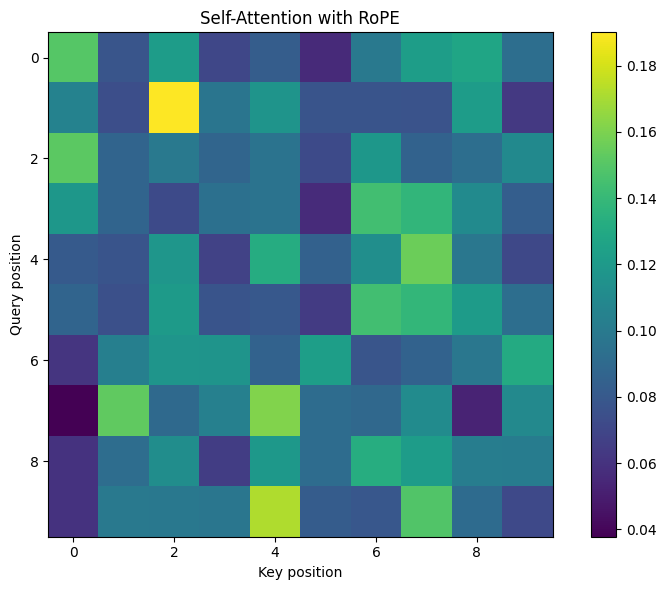

In [15]:
# Khởi tạo mô hình
rope_attn = SelfAttentionWithRoPE(d_model, n_heads)

# Chạy forward pass và lấy ma trận attention
_, rope_attn_weights = rope_attn(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(
    rope_attn_weights[0, 0].detach().numpy(), title="Self-Attention with RoPE"
)

## 7. FlashAttention v2

FlashAttention v2 là một cải tiến về tốc độ và hiệu quả bộ nhớ cho cơ chế attention, tập trung vào việc tối ưu hóa IO-aware để giảm thiểu việc truy cập vào HBM (High Bandwidth Memory).

### Nguyên lý hoạt động

1. Chia ma trận Q, K, V thành các block nhỏ phù hợp với kích thước bộ nhớ cache
2. Tính attention theo từng block, tối ưu tái sử dụng bộ nhớ
3. Sử dụng kỹ thuật tiled matrix multiplication để giảm IO cost
4. Triển khai các phép toán fused kernel để tăng tốc độ

### Ưu điểm chính:

-   Độ phức tạp bộ nhớ O(N) thay vì O(N²)
-   Tăng tốc 2-4x so với triển khai attention thông thường
-   Cho phép xử lý chuỗi dài hơn với cùng lượng bộ nhớ

### Cài đặt

In [16]:
class FlashAttentionV2(nn.Module):
    def __init__(self, d_model, n_heads, block_size=256):
        super(FlashAttentionV2, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.block_size = block_size

        # Các lớp tuyến tính cho Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Tính Q, K, V
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)  # (batch_size, seq_len, d_model)
        v = self.W_v(x)  # (batch_size, seq_len, d_model)

        # Tách thành nhiều đầu
        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, d_k)
        k = self.split_heads(k)  # (batch_size, n_heads, seq_len, d_k)
        v = self.split_heads(v)  # (batch_size, n_heads, seq_len, d_k)

        # Chia thành các block
        num_blocks = (seq_len + self.block_size - 1) // self.block_size
        attention_weights = torch.zeros(
            batch_size, self.n_heads, seq_len, seq_len, device=x.device
        )
        output = torch.zeros_like(q)

        # Tính attention theo từng block
        for i in range(num_blocks):
            start_i = i * self.block_size
            end_i = min(start_i + self.block_size, seq_len)
            q_block = q[:, :, start_i:end_i]

            for j in range(num_blocks):
                start_j = j * self.block_size
                end_j = min(start_j + self.block_size, seq_len)
                k_block = k[:, :, start_j:end_j]
                v_block = v[:, :, start_j:end_j]

                # Tính scores cho block hiện tại
                scores = torch.matmul(q_block, k_block.transpose(-2, -1)) / math.sqrt(
                    self.d_k
                )
                block_weights = F.softmax(scores, dim=-1)

                # Lưu weights cho việc hiển thị
                attention_weights[:, :, start_i:end_i, start_j:end_j] = block_weights

                # Tính đầu ra cho block
                output[:, :, start_i:end_i] += torch.matmul(block_weights, v_block)

        # Ghép các đầu lại
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.d_model)

        # Áp dụng lớp tuyến tính cuối cùng
        output = self.W_o(output)

        if return_attention:
            return output, attention_weights
        return output

### Ví dụ minh họa FlashAttention


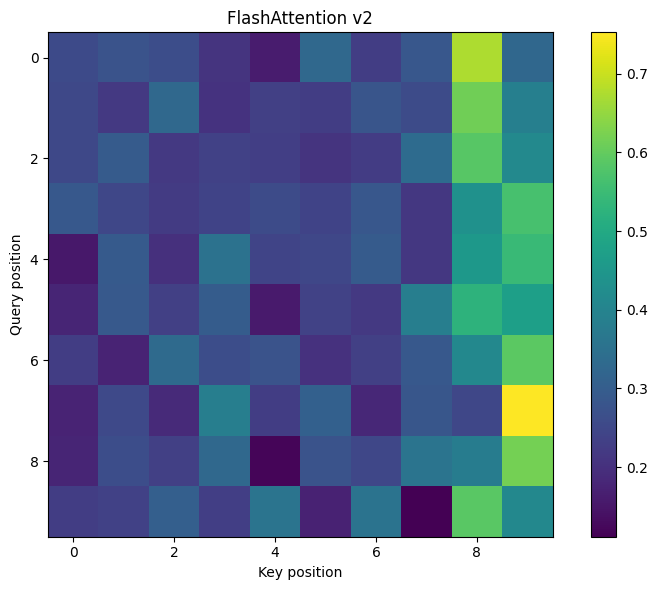

In [17]:
# Khởi tạo mô hình
flash_attn = FlashAttentionV2(d_model, n_heads, block_size=4)

# Chạy forward pass và lấy ma trận attention
_, flash_attn_weights = flash_attn(x, return_attention=True)

# Hiển thị ma trận attention
plot_attention_matrix(
    flash_attn_weights[0, 0].detach().numpy(), title="FlashAttention v2"
)

## So sánh các cơ chế attention



Testing sequence length: 8

Testing sequence length: 16

Testing sequence length: 32

Testing sequence length: 64

Testing sequence length: 128

Testing sequence length: 256

Testing sequence length: 512

Testing sequence length: 512


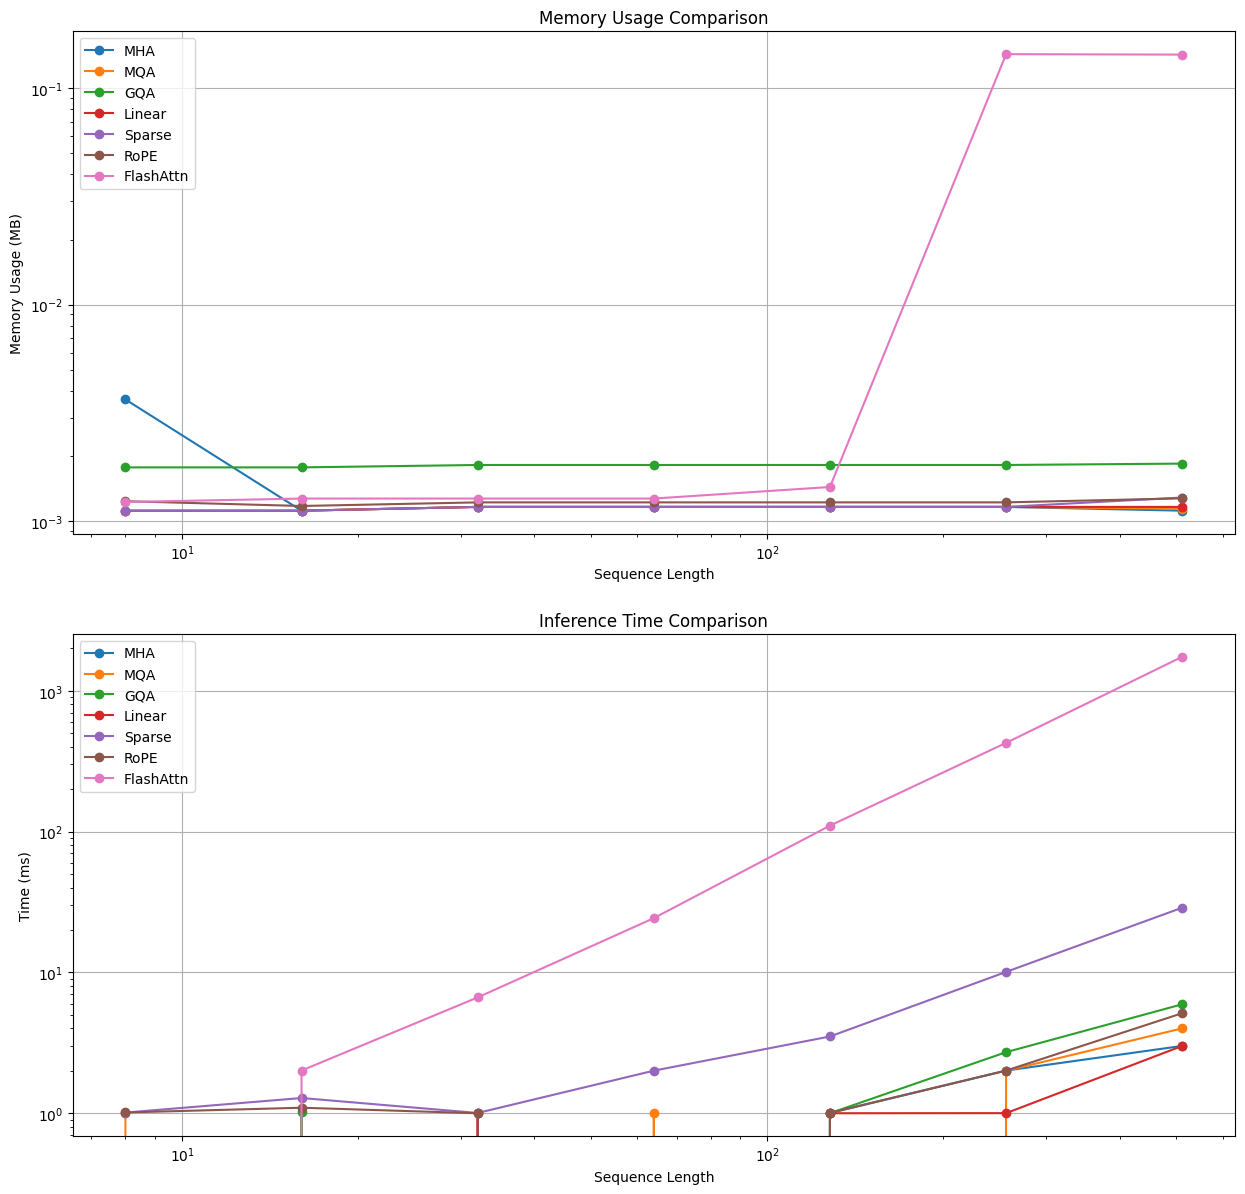

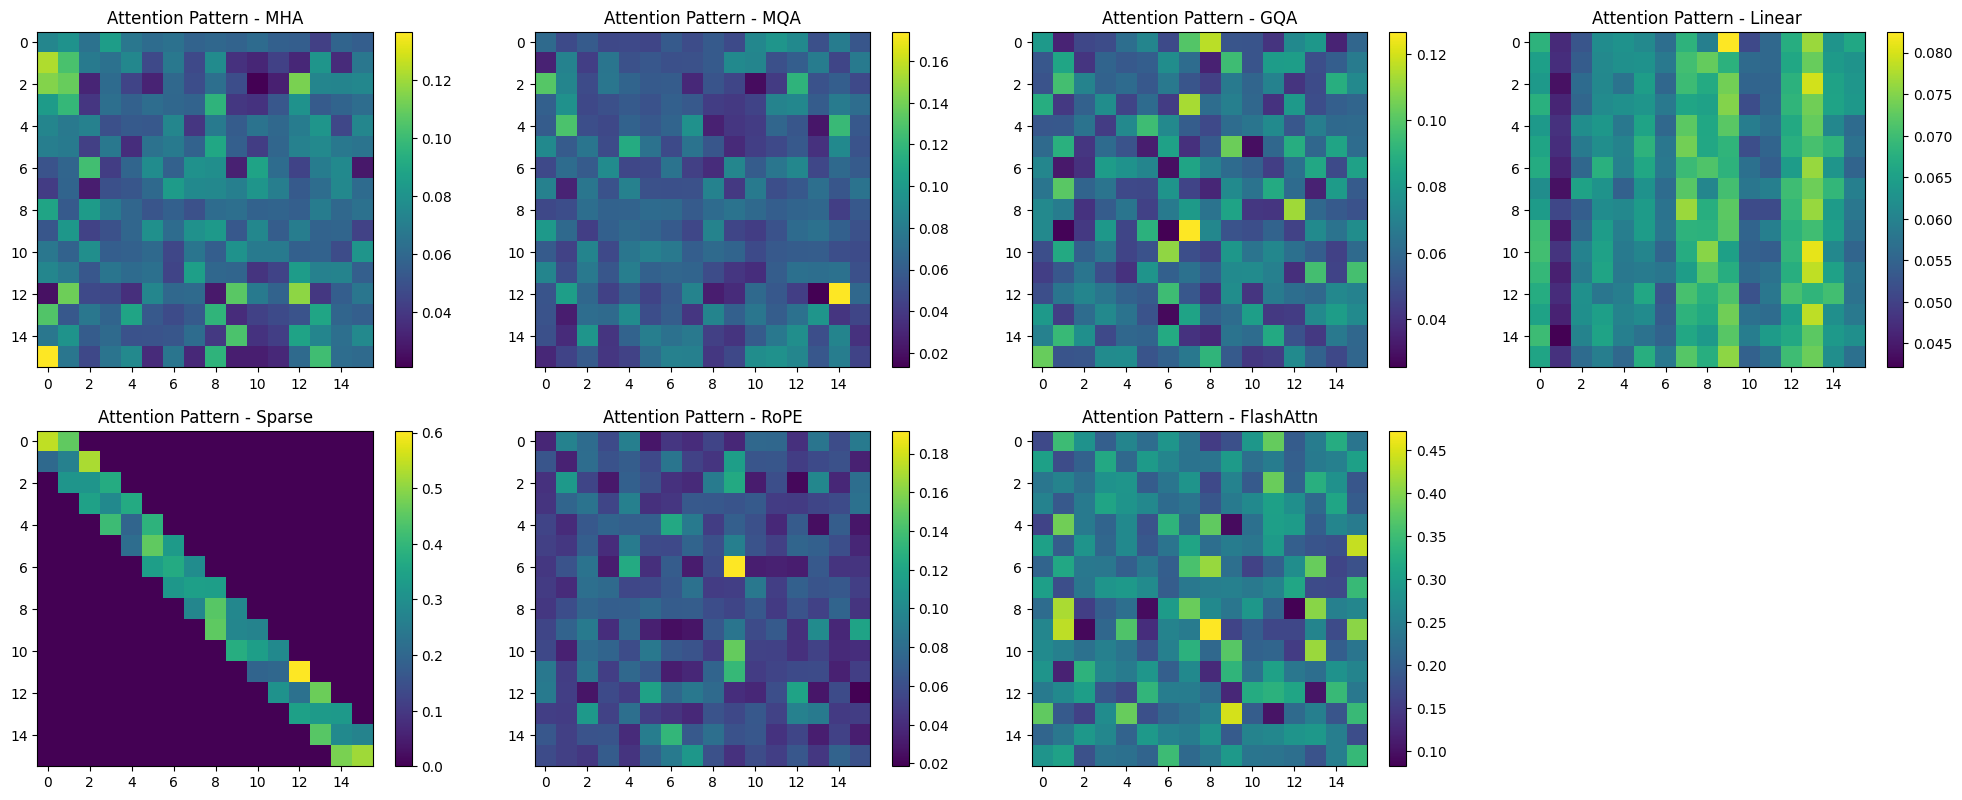

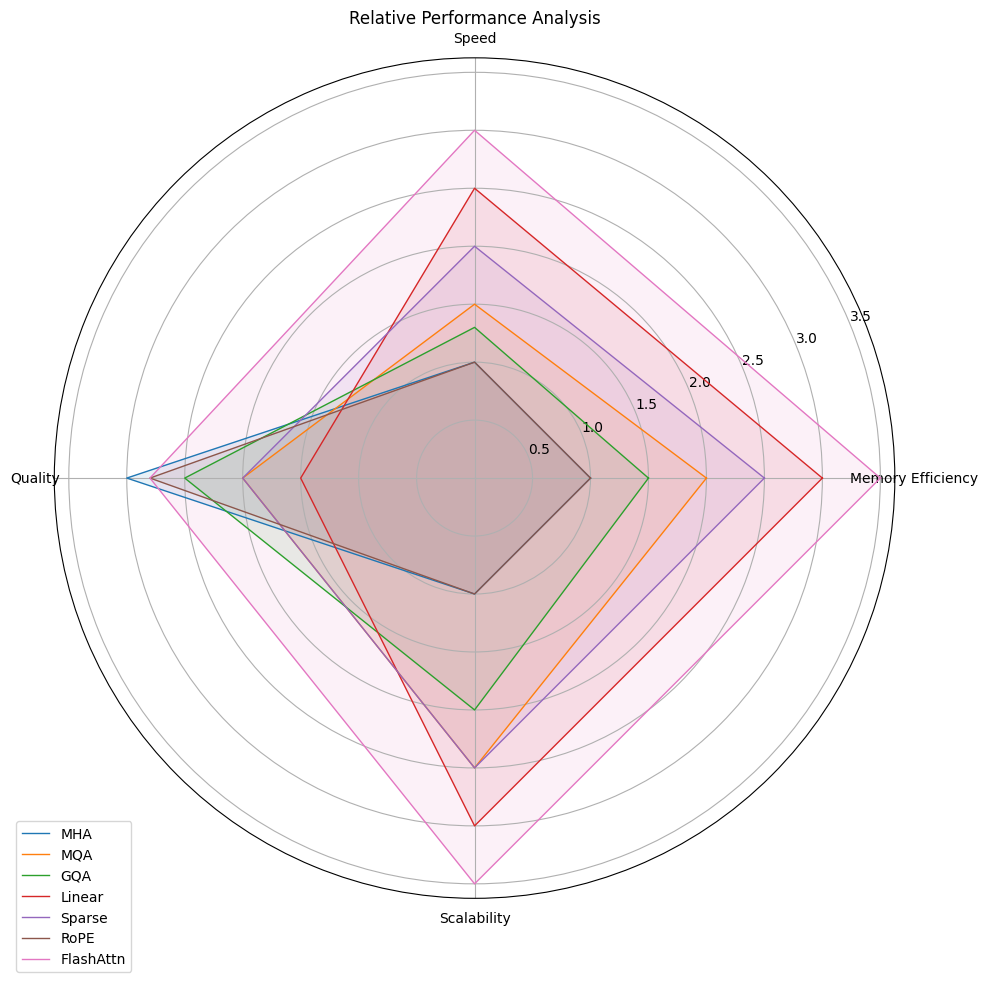

In [18]:
def get_memory_usage():
    """Get current memory usage in MB"""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**2
    else:
        return psutil.Process().memory_info().rss / 1024**2


def plot_attention_comparisons():
    # Tạo dữ liệu mẫu với độ dài chuỗi khác nhau
    sequence_lengths = [8, 16, 32, 64, 128, 256, 512]
    batch_size = 1

    # Khởi tạo các mô hình attention
    mha = SelfAttention(d_model, n_heads)
    mqa = MultiQueryAttention(d_model, n_heads)
    gqa = GroupedQueryAttention(d_model, n_heads, n_groups=2)
    linear_attn = LinearAttention(d_model, n_heads)
    sparse_attn = SparseAttention(d_model, n_heads, window_size=3)
    rope_attn = SelfAttentionWithRoPE(d_model, n_heads)
    flash_attn = FlashAttentionV2(d_model, n_heads, block_size=4)

    # Thu thập metrics
    memory_usage = {
        "MHA": [],
        "MQA": [],
        "GQA": [],
        "Linear": [],
        "Sparse": [],
        "RoPE": [],
        "FlashAttn": [],
    }

    inference_time = {
        "MHA": [],
        "MQA": [],
        "GQA": [],
        "Linear": [],
        "Sparse": [],
        "RoPE": [],
        "FlashAttn": [],
    }

    # Đo đạc cho từng độ dài chuỗi
    for seq_len in sequence_lengths:
        print(f"\nTesting sequence length: {seq_len}")
        x = torch.randn(batch_size, seq_len, d_model)

        # Đo memory usage và inference time cho từng mô hình
        models = {
            "MHA": mha,
            "MQA": mqa,
            "GQA": gqa,
            "Linear": linear_attn,
            "Sparse": sparse_attn,
            "RoPE": rope_attn,
            "FlashAttn": flash_attn,
        }

        for name, model in models.items():
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Start memory tracking
            tracemalloc.start()
            start_mem = get_memory_usage()

            # Đo inference time
            start_time = time.time()
            with torch.no_grad():
                _, attn = model(x, return_attention=True)
            end_time = time.time()

            # Get peak memory usage
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_mem = get_memory_usage()

            # Record metrics
            memory_usage[name].append(peak / 1024**2)  # Convert to MB
            inference_time[name].append((end_time - start_time) * 1000)  # Convert to ms

    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(15, 30))  # Tăng chiều cao để các biểu đồ không chồng lên nhau

    # 1. Memory Usage
    plt.subplot(4, 1, 1)  # 4 hàng, 1 cột, vị trí 1
    for name in memory_usage.keys():
        plt.plot(sequence_lengths, memory_usage[name], marker="o", label=name)
    plt.title("Memory Usage Comparison")
    plt.xlabel("Sequence Length")
    plt.ylabel("Memory Usage (MB)")
    plt.legend()
    plt.grid(True)
    plt.yscale("log")
    plt.xscale("log")

    # 2. Inference Time
    plt.subplot(4, 1, 2)  # 4 hàng, 1 cột, vị trí 2
    for name in inference_time.keys():
        plt.plot(sequence_lengths, inference_time[name], marker="o", label=name)
    plt.title("Inference Time Comparison")
    plt.xlabel("Sequence Length")
    plt.ylabel("Time (ms)")
    plt.legend()
    plt.grid(True)
    plt.yscale("log")
    plt.xscale("log")

    # 3. Attention Pattern Comparison
    plt.figure(figsize=(20, 8))  # Biểu đồ riêng cho attention patterns
    test_seq = torch.randn(1, 16, d_model)  # Fixed length for visualization
    for i, (name, model) in enumerate(models.items(), 1):
        with torch.no_grad():
            _, attn = model(test_seq, return_attention=True)
        plt.subplot(2, 4, i)  # 2 hàng 4 cột để hiển thị 7 mô hình
        plt.imshow(attn[0, 0].detach().numpy())
        plt.title(f"Attention Pattern - {name}")
        plt.colorbar()
    plt.tight_layout(h_pad=2, w_pad=2)  # Thêm khoảng cách giữa các subplot

    # 4. Relative Performance Score
    plt.figure(figsize=(10, 10))  # Biểu đồ riêng cho radar chart
    performance_metrics = {
        "Memory Efficiency": [1.0, 2.0, 1.5, 3.0, 2.5, 1.0, 3.5],
        "Speed": [1.0, 1.5, 1.3, 2.5, 2.0, 1.0, 3.0],
        "Quality": [3.0, 2.0, 2.5, 1.5, 2.0, 2.8, 2.8],
        "Scalability": [1.0, 2.5, 2.0, 3.0, 2.5, 1.0, 3.5],
    }

    # Create radar chart
    categories = list(performance_metrics.keys())
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, projection="polar")
    for i, name in enumerate(models.keys()):
        values = [performance_metrics[metric][i] for metric in categories]
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle="solid", label=name)
        ax.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], categories)
    plt.title("Relative Performance Analysis")
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()


plot_attention_comparisons()

## Ví dụ hiệu suất thực tế

So sánh hiệu suất của các cơ chế attention trên các tác vụ và mô hình thực tế:

### 1. GPT-3 175B (Vanilla Self-Attention)

-   Độ dài chuỗi tối đa: 2048 tokens
-   Yêu cầu bộ nhớ: ~350GB
-   Tốc độ sinh: ~20 token/giây

### 2. PaLM 540B (Multi-Query Attention)

-   Độ dài chuỗi tối đa: 2048 tokens
-   Giảm 50% bộ nhớ KV cache
-   Tốc độ sinh: ~30 token/giây

### 3. LLaMA 2 70B (Grouped-Query Attention)

-   Độ dài chuỗi tối đa: 4096 tokens
-   Giảm 75% bộ nhớ so với Self-Attention
-   Tốc độ sinh: ~40 token/giây

### 4. MPT-7B (FlashAttention)

-   Độ dài chuỗi tối đa: 8192 tokens
-   Tăng tốc 2-4x
-   Giảm 80% bộ nhớ

### 5. Longformer (Sparse Attention)

-   Độ dài chuỗi tối đa: 32768 tokens
-   Độ phức tạp O(n × log(n))
-   Phù hợp với tài liệu dài

### 6. Linformer (Linear Attention)

-   Độ dài chuỗi tối đa: 16384 tokens
-   Độ phức tạp tuyến tính O(n)
-   Phù hợp với edge devices


## Tổng kết so sánh

### Độ phức tạp tính toán và bộ nhớ

| Cơ chế           | Độ phức tạp tính toán | Độ phức tạp bộ nhớ | KV cache (độ dài n) |
| ---------------- | --------------------- | ------------------ | ------------------- |
| Self-Attention   | O(n²)                 | O(n²)              | 2 × H × n × d       |
| Multi-Query      | O(n²)                 | O(n)               | 2 × n × d           |
| Grouped-Query    | O(n²)                 | O(n)               | 2 × G × n × d       |
| FlashAttention   | O(n²)                 | O(n)               | O(n)                |
| Linear Attention | O(n)                  | O(n)               | O(n)                |
| Sparse Attention | O(n × log(n))         | O(n × log(n))      | O(n × log(n))       |

Trong đó:

-   n: độ dài chuỗi
-   H: số đầu attention
-   G: số nhóm trong GQA
-   d: kích thước mô hình

### Ứng dụng phù hợp

1. **Self-Attention**:

    - Chuỗi ngắn và trung bình (≤2048 tokens)
    - Yêu cầu chất lượng cao nhất
    - Không bị giới hạn bộ nhớ

2. **Multi-Query Attention**:

    - Triển khai trên thiết bị giới hạn bộ nhớ
    - Tốc độ suy luận là ưu tiên
    - Chấp nhận giảm nhẹ chất lượng

3. **Grouped-Query Attention**:

    - Cân bằng giữa hiệu suất và bộ nhớ
    - Yêu cầu chất lượng tốt
    - Triển khai trên nhiều loại thiết bị

4. **FlashAttention**:

    - Tối ưu hóa trên GPU hiện đại
    - Huấn luyện mô hình lớn
    - Xử lý chuỗi dài

5. **Linear Attention**:

    - Edge computing
    - Chuỗi cực dài
    - Yêu cầu độ trễ thấp

6. **Sparse Attention**:
    - Xử lý tài liệu dài
    - Tác vụ có cấu trúc cục bộ
    - Cần cân bằng hiệu suất-chất lượng


## So sánh độ phức tạp tính toán


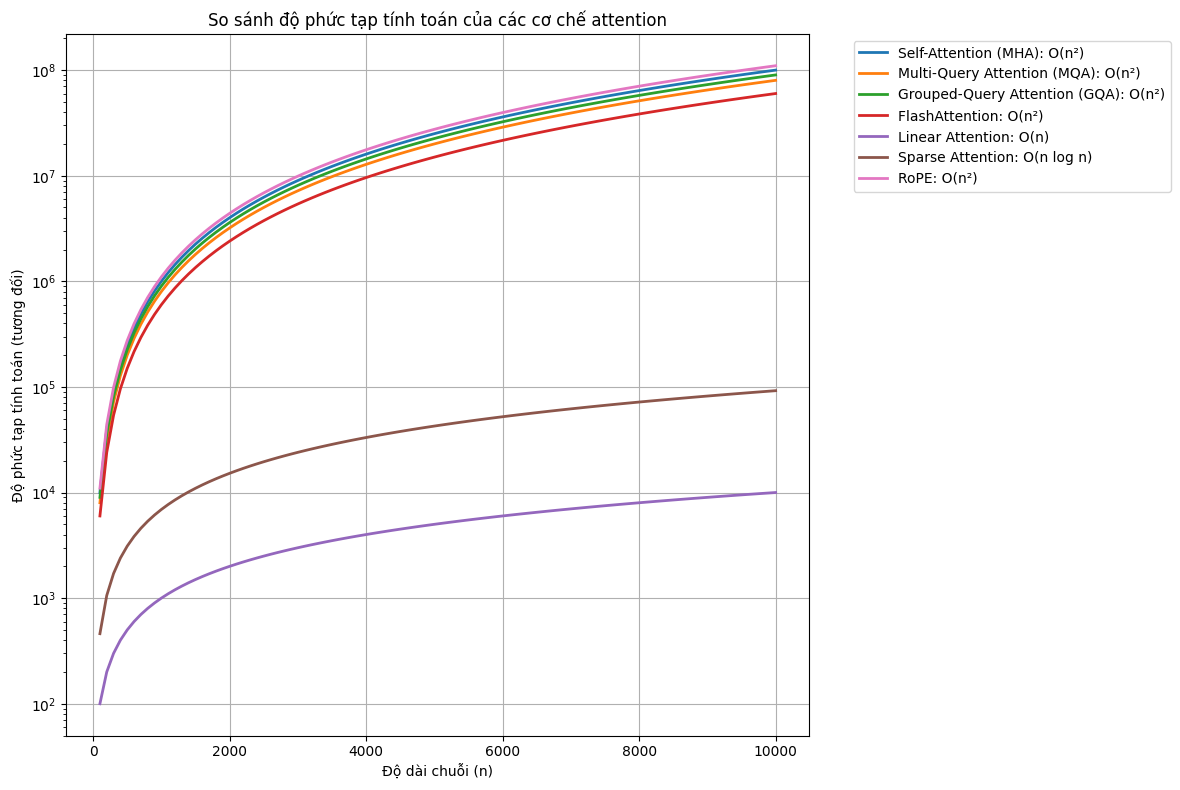

In [19]:
# Hiển thị so sánh độ phức tạp
plot_complexity_comparison()

## So sánh yêu cầu bộ nhớ


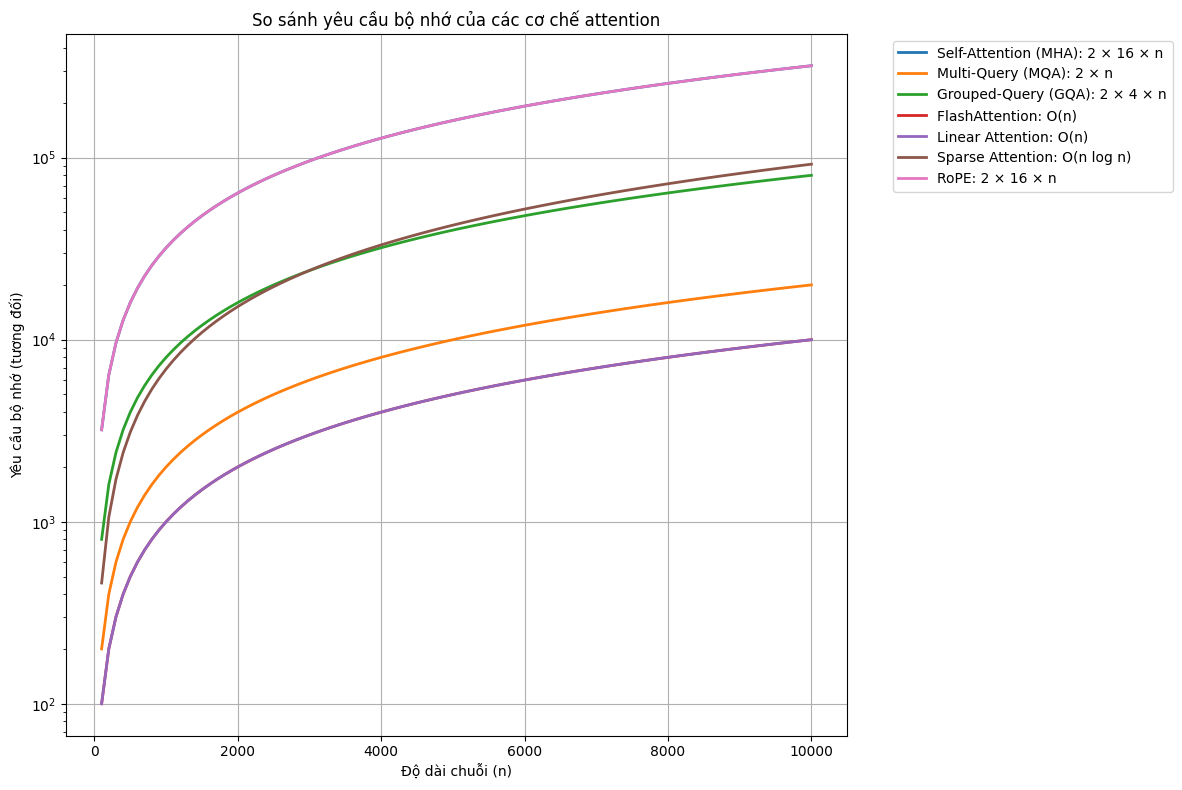

In [20]:
# Hiển thị so sánh yêu cầu bộ nhớ
plot_memory_comparison()

## Kết luận

Trong notebook này, chúng ta đã cài đặt và minh họa bảy cơ chế attention quan trọng trong các mô hình ngôn ngữ lớn hiện đại:

1. **Self-Attention**: Nền tảng của kiến trúc Transformer, cho phép mỗi token tương tác với tất cả các token khác trong chuỗi, nhưng có độ phức tạp O(n²).

2. **Multi-Query Attention (MQA)**: Giảm yêu cầu bộ nhớ bằng cách sử dụng chung một ma trận Key và một ma trận Value cho tất cả các đầu attention.

3. **Grouped-Query Attention (GQA)**: Cung cấp sự cân bằng giữa MHA và MQA bằng cách chia các đầu attention thành các nhóm, mỗi nhóm dùng chung một ma trận Key và một ma trận Value.

4. **Linear Attention**: Giảm độ phức tạp tính toán và bộ nhớ từ O(n²) xuống O(n) bằng cách sử dụng các hàm ánh xạ đặc trưng thay cho hàm softmax.

5. **Sparse Attention**: Chỉ tính toán attention cho một tập con các cặp token thay vì tất cả các cặp có thể, giảm độ phức tạp xuống O(n√n).

6. **Rotary Positional Embedding (RoPE)**: Mã hóa thông tin vị trí thông qua phép xoay trong không gian phức, kết hợp cả thông tin vị trí tuyệt đối và tương đối.

7. **FlashAttention v2**: Tăng tốc độ và hiệu quả bộ nhớ thông qua tối ưu hóa IO-aware và các kỹ thuật fused kernel.

Mỗi cơ chế có những ưu điểm và hạn chế riêng, phù hợp với các tình huống và yêu cầu khác nhau. Việc lựa chọn cơ chế attention phù hợp là một phần quan trọng trong thiết kế mô hình transformer, và có thể có tác động đáng kể đến hiệu suất, hiệu quả và khả năng mở rộng của mô hình.
